In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [90]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 6
EPOCHS = 15

DATA_DIR = "../data/rice_split"

print("Configuration:")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Epochs: {EPOCHS}")

Configuration:
  Image size: (160, 160)
  Batch size: 32
  Classes: 6
  Epochs: 15


In [91]:
train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
)

CLASS_NAMES = train_ds.class_names
print("\n✓ Datasets loaded")
print(f"Classes: {CLASS_NAMES}")

Found 2678 files belonging to 6 classes.
Found 571 files belonging to 6 classes.

✓ Datasets loaded
Classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']


In [92]:
def preprocess_mobilenet(image, label):
    """Apply MobileNetV3 preprocessing: scale to [-1, 1]"""
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

def augment_image(image, label):
    """Apply augmentation - only used on training set"""
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random rotation (±10%)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    
    return image, label

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)

# Apply augmentation ONLY to training set (in pipeline, not in model)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize pipeline
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

print("✓ Preprocessing applied to datasets")
print("✓ Augmentation applied to training set only")

✓ Preprocessing applied to datasets
✓ Augmentation applied to training set only


In [62]:
base_model = keras.applications.MobileNetV3Small(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # Freeze base model

# Build model WITHOUT augmentation layers
inputs = keras.Input(shape=IMG_SIZE + (3,), dtype=tf.float32)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="rice_classifier")

print("✓ Model built (no augmentation layers)")
print(f"✓ Total parameters: {model.count_params():,}")

/Users/macbook/Desktop/rice-disease-edge-ai/.venv/lib/python3.9/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


✓ Model built
✓ Total parameters: 1,016,054


In [93]:
# Load pre-trained base model
base_model = keras.applications.MobileNetV3Small(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # Freeze base model

# Build model WITHOUT augmentation layers
inputs = keras.Input(shape=IMG_SIZE + (3,), dtype=tf.float32)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="rice_classifier")

print("✓ Model built (no augmentation layers)")
print(f"✓ Total parameters: {model.count_params():,}")


/Users/macbook/Desktop/rice-disease-edge-ai/.venv/lib/python3.9/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


✓ Model built (no augmentation layers)
✓ Total parameters: 1,016,054


In [94]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

print("✓ Model compiled")
model.summary()

✓ Model compiled


Model: "rice_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 5, 5, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 576)            │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,054 (3.88 MB)

 Trainable params: 75,782 (296.02 KB)

 Non-trainable params: 940,272 (3.59 MB)

In [95]:
print("\n" + "="*60)
print("TRAINING")
print("="*60)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

print("\n✓ Training complete!")


TRAINING
Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.3883 - loss: 1.8037 - val_accuracy: 0.6357 - val_loss: 1.0195
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.6645 - loss: 0.9175 - val_accuracy: 0.7198 - val_loss: 0.7797
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7289 - loss: 0.7473 - val_accuracy: 0.7863 - val_loss: 0.6508
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.7588 - loss: 0.6319 - val_accuracy: 0.8021 - val_loss: 0.5828
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8029 - loss: 0.5566 - val_accuracy: 0.8214 - val_loss: 0.5169
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8044 - loss: 0.5428 - val_accuracy: 0.8406 - val_loss: 0.4760
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.8437 - loss: 0.4530 - val_accuracy: 0.8616 - val_loss: 0.4415
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.8379 - loss: 0.4470 - val_accuracy: 

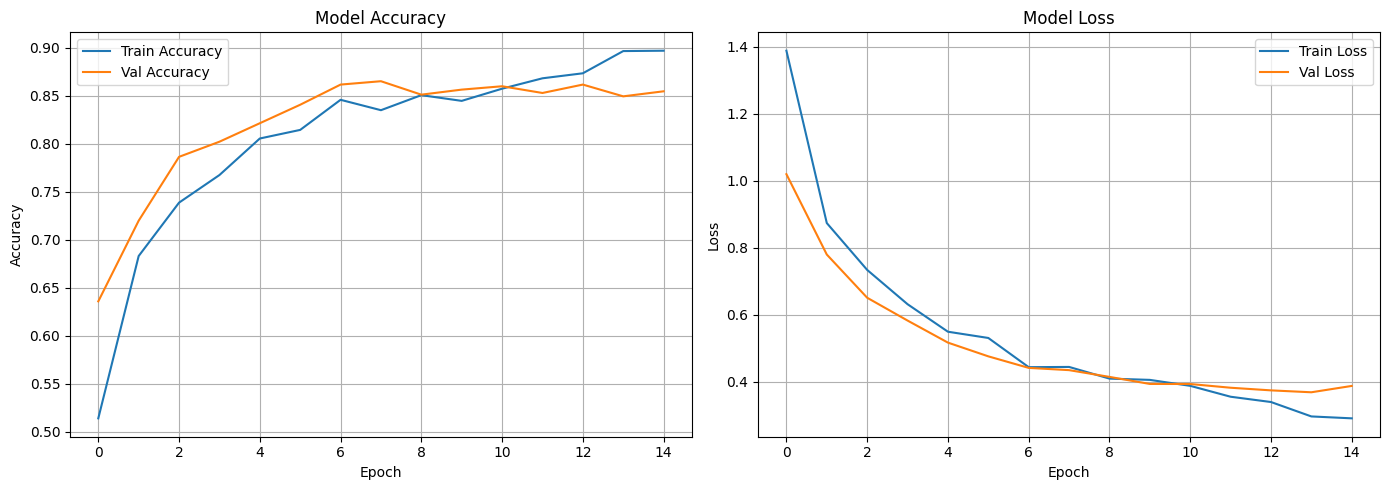

Final Training Accuracy: 89.69%
Final Validation Accuracy: 85.46%


In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")

In [97]:
print("\n" + "="*60)
print("VALIDATION EVALUATION")
print("="*60)

val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc*100:.2f}%")



VALIDATION EVALUATION
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8760 - loss: 0.3641

Validation Loss: 0.3877
Validation Accuracy: 85.46%


In [98]:
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))



CLASSIFICATION REPORT
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.80      0.86      0.83        95
           Brown Spot       0.88      0.82      0.85        96
    Healthy Rice Leaf       0.95      0.94      0.94        97
           Leaf Blast       0.87      0.81      0.84        95
           Leaf scald       0.82      0.80      0.81        94
        Sheath Blight       0.82      0.89      0.86        94

             accuracy                           0.85       571
            macro avg       0.86      0.85      0.85       571
         weighted avg       0.86      0.85      0.85       571



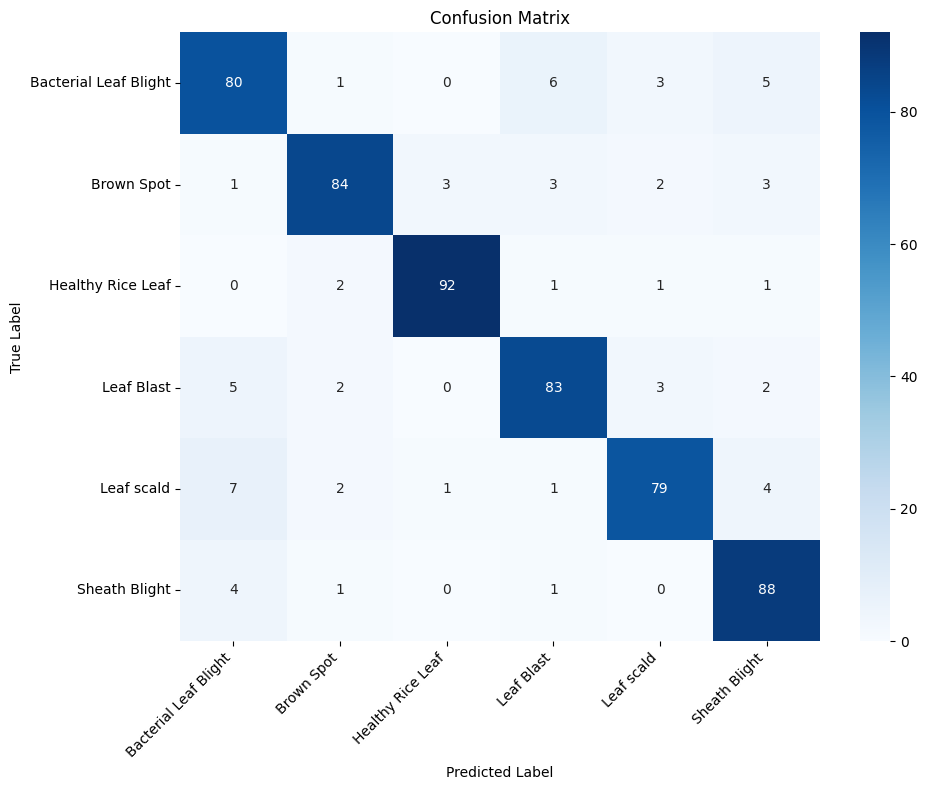

In [99]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [103]:
# Save in Keras format
model.save("../models/baseline/mobilenetv3small_infer/rice_model_baseline.keras")
print("✅ Model saved to: models/baseline/mobilenetv3small_infer/rice_model_baseline.keras")

# Also save in SavedModel format for TFLite conversion
model.export("../models/baseline/mobilenetv3small")
print("✅ SavedModel exported to: models/baseline/mobilenetv3small")


✅ Model saved to: models/baseline/mobilenetv3small_infer/rice_model_baseline.keras
INFO:tensorflow:Assets written to: ../models/baseline/mobilenetv3small/assets


INFO:tensorflow:Assets written to: ../models/baseline/mobilenetv3small/assets


Saved artifact at '../models/baseline/mobilenetv3small'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_1476')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  6441272064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11040899664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11040899312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6410581264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11040901072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11023437488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6329057696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6329061040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6329060160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6329059984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11023329584: TensorSpec(shape=(), dt

In [105]:
from pathlib import Path

saved_model_size = sum(f.stat().st_size for f in Path("../models/baseline/mobilenetv3small").rglob('*') if f.is_file())
print(f"\nBaseline model size: {saved_model_size / (1024*1024):.2f} MB")
print("\n📝 Next step: Convert to TFLite using the conversion script")


Baseline model size: 9.21 MB

📝 Next step: Convert to TFLite using the conversion script


In [106]:
import os

DATA_DIR = "../data/rice_split"

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} SET:")
    split_dir = os.path.join(DATA_DIR, split)
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
            print(f"  {class_name}: {count}")


TRAIN SET:
  Bacterial Leaf Blight: 445
  Brown Spot: 452
  Healthy Rice Leaf: 457
  Leaf Blast: 443
  Leaf scald: 439
  Sheath Blight: 442

VAL SET:
  Bacterial Leaf Blight: 95
  Brown Spot: 96
  Healthy Rice Leaf: 97
  Leaf Blast: 95
  Leaf scald: 94
  Sheath Blight: 94

TEST SET:
  Bacterial Leaf Blight: 96
  Brown Spot: 98
  Healthy Rice Leaf: 99
  Leaf Blast: 96
  Leaf scald: 95
  Sheath Blight: 96
